# 15688 Final Project: Genre classification of songs using lyrics text analysis

Submitted by Priyadarshini Mitra, Keerthy Muralidharan and Mahesh Kumar Srinivas

<img src="img/MUSIC.jpg">

## Introduction

Music Classification is a fairly common topic, and there are many ways to classify songs on features like danceability, energy, tempo, etc. Indeed, classifying songs on these features is so commonplace that commercial music streaming services like Spotify provide an off the shelf solution to retrieve these audio features, and others like

1. Danceability
2. Energy
3. Loudness
4. Speechiness
5. Acousticness
6. Tempo

These are audio features that are readily available for use through the Spotify API.

We differentiate our classification by one fundamental change - Lyrics. Every genre has several issues/subjects that it tackles. By identifying these topics as most frequently occurring words, we're able to accurately classify songs that deal with similar topics and contain similar words.

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib
import requests

## Data Collection

In order to work with the lyrics _and_ the genre of the songs, we had to combine data from a variety of sources. No existing dataset contained all the information for us to work with.

These are our primary sources of the data:

Listed below is our approach to this problem.

### 1. Million Song Dataset (LabROSA)

In order to get the actual songs to be used, we used the million song dataset, which is a freely-available collection of audio features and metadata for a million contemporary popular music tracks.

The artist and track information for a million unique tracks are available, and were used to fetch more data, namely their Genre and Lyrics.

### 2. LyricWiki

LyricWiki (lyrics.wikia.com) is an online wiki-based lyrics database and encyclopaedia. The lyrics on LyricWiki are all licensed through LyricFind.

We use the artist and the track to retreive lyrics. All songs on LyricsWiki follow the same URL pattern:

http://lyrics.wikia.com/wiki/Opeth:Blackwater_Park (Opeth is the Artist Name, and Blackwater Park is the song name.)

Using standard web scraping through BeautifulSoup, we're able to extract the lyrics of the songs. In order to ensure we retrieve only songs in English, a meta tag is checked for the language of the song.

Any songs with no lyrics, or non-english lyrics are removed from the dataset.

In [ ]:
def retrieve_lyrics(file):
    song_df = pd.read_csv(file)
    song_dict={}
    for i in range(len(song_df)):
        songunique = str(song_df.iloc[i]['Artist'])+","+str(song_df.iloc[i]['Song'])
        flag=True
        print(songunique)
        for x in range(len(songunique)):
            if ord(songunique[x])>=128:
                flag=False
        if flag==True:
            try:
                #This is the url constructed given the artist and track name
                url = "http://lyrics.wikia.com/wiki/"+song_df.iloc[i]['Artist'].replace(" ","_")+":"+song_df.iloc[i]['Song'].replace(" ","_")
                resp = urllib.request.urlopen(url)
                root = BeautifulSoup(resp.read(),"html.parser")
                meta = root.find("meta", attrs={"name":"keywords"})
                if "English" in str(meta):
                    lyr = root.find("div", class_="lyricbox")
                    string = str(lyr).replace("<br/>"," ")[22:-38]
                else:
                    string = "null"
            except urllib.error.HTTPError as err:
                if err.code!=200:
                    string = "null"
                else:
                    raise
        else:
            string="null"
        song_dict[songunique]=string


    lyr_dict = {}
    for k,v in song_dict.items():
        if v != "null":
            lyr_dict[k]=v
            
    lyr_df = pd.DataFrame(list(lyr_dict.items()), columns = ['Song', 'Lyrics'])
    
    return lyr_df    
    

### 3. Last.fm API

Last.fm is a website that "scrobbles" or identifies and records the songs that users listen to. It has information about millions of songs, like Artist, Album, Genre, Release Date, etc. These tags are all community contributed.

Using calls to the Last.fm API, we retrieve the tag level information of songs, as a JSON object. This object is parsed to identify the genre of all the songs in the dataset.

The resultant dataframe is further cleaned, by clubbing together similar genres. E.g., Progressive Metal, Death Metal, Heavy Metal, and other subgenres of metal are clubbed into a single Metal genre. A similar process is used for other genres like rap and hip-hop, dance, disco, etc.

In [ ]:
def retrieve_genres(df, api_key):
    genreList=[]
    
    for i in range(len(df)):
        urlString = "http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key="+api_key
        artist = df.iloc[i]['Artist']
        track = df.iloc[i]['Song']
        print(i, artist, track)
        urlString+="&artist="+artist.lower()+"&track="+track.lower()+"&format=json"
        response = requests.get(urlString).json()
        try:
            genre = response['track']['toptags']['tag'][0]['name']
        except (IndexError,KeyError,ValueError,ConnectionError):
            genre = "null"
        genreList.append(genre)
        
    df['Genre']=pd.Series(genreList)
    
    return df

Using the genre information extracted from Last.fm, we are further cleaning the data, by removing all null genres, and any genre that hasn't occurred atleast 30 times in the dataset.

We are further clubbing together subgenres into their parent genre.

In [ ]:
def remove_nulls():
    lyrics_df=lyrics_df[ lyrics_df['Genre'] != "null" ] 
    lyrics_df.reset_index()
    lyrics_counter=dict(Counter(lyrics_df['Genre']))
    genres=[k for k in lyrics_counter.keys() if lyrics_counter[k]>30]

    lyrics_genre_df = lyrics_df[ lyrics_df['Genre'].isin(genres)]
    lyrics_genre_df.to_csv("genre_clean2.csv")

In [ ]:
def club_genres(df):
    gen_parent = []
    for i in range(len(df)):
        genre = df.iloc[i]['Genre']
        if "metal" in genre.lower() or "industrial" in genre.lower() or "hardcore" in genre.lower() :
            #Clubbing together all metal subgenres
            gen_parent.append('Metal')
        elif "rock" in genre.lower() or "grunge" in genre.lower():
            #Clubbing together all rock subgenres
            gen_parent.append('Rock')
        elif "hop" in genre.lower() or "rap" in genre.lower():
            #Clubbing together rap and hip-hop
            gen_parent.append("Hip Hop")
        elif "pop" in genre.lower():
            #Clubbing together all pop subgenres
            gen_parent.append('Pop')
        elif "punk" in genre.lower():
            #Clubbing together all punk subgenres
            gen_parent.append("Punk")
        elif "disco" in genre.lower() or "dance" in genre.lower() or "trance" in genre.lower():
            #Clubbing together all dance and disco music
            gen_parent.append("Dance/Disco")
        elif "christ" in genre.lower():
            #Clubbing together all christian and christmas music
            gen_parent.append("Christian")
        else:
            gen_parent.append(genre)

    df['Genre'] = pd.Series(gen_parent)
    return df

Once the data was scraped we cleansed the data using the following modules. We removed 'nulls' we had appended in the dataframe. Filtered the dataframe based on genre and took only those genres that were present more than 1000 times.We removed numbers, special characters, common words like "Verse", "Version", "Chorus" from Songs and Lyrics.

In [231]:
import csv
import nltk
import pandas as pd
import numpy as np
import sklearn
import string
from collections import Counter
import gensim
import sklearn.manifold
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as mt
import numpy as np
import seaborn as sb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as mt
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import multiprocessing
import wordcloud
from wordcloud import WordCloud
import re
import os

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [232]:
genre_clean_labels=pd.read_csv("lyrics_final_data.csv",encoding = 'utf8')
genre_clean_labels = genre_clean_labels[genre_clean_labels['Genre']!='null']
genre_clean_labels['Genre'] = genre_clean_labels['Genre'].str.lower()

genre_counter=dict(Counter(genre_clean_labels['Genre']))
genres_1=[k for k in genre_counter.keys() if genre_counter[k]>1000]
print(genres_1)

genre_clean_labels = genre_clean_labels[genre_clean_labels['Genre'].isin(genres_1)]

genre_clean_labels= genre_clean_labels[genre_clean_labels['Genre']!='female vocalists']

genre_clean_labels.reset_index(drop=True)

df=genre_clean_labels

df.groupby('Genre').count()

data=df

genres=list(df['Genre'].unique())

genres = [x.lower() for x in genres]
 
genre_label=[]

for row in df.iterrows(): 
    gen = getattr(row[1], 'Genre')
    genre_label.append(genres.index(gen.lower()))

class_lab = np.asarray(genre_label)
 
data['labels']=class_lab
data = data.reset_index(drop=True)
len(data['labels'])

data.head()

['indie', 'country', 'pop', 'rock', 'metal']


,Artist,Song,Lyrics,Genre,labels
0,Dear Reader,Dearheart,I never wrote a love song That didn't go 'woe ...,indie,0
1,Tammy Wynette,D-I-V-O-R-C-E,Our little boy is four years old and quite a l...,country,1
2,Cheryl Cole,Fight For This Love,Too much of anything can make you sick Even th...,pop,2
3,Sugar Ray,Burning Dog,Look around help me out Breaking up breaking d...,rock,3
4,Chely Wright,Broken,Why can't you just believe in me? Not everyone...,country,1


In [233]:
def remove_noise(text):    
    proc = re.sub(r'\(.*?\)','',text)
    proc = re.sub(r'\[.*?\]','',text)
    proc = re.sub(r'\,.*?,',' ',text)
    proc = re.sub(r'\'|\?',' ',text)
    proc = re.sub(r'[V|v]erse','',text)
    proc = re.sub(r'[v|V]ersion','',text)
    proc = re.sub(r'[c|C]horus','',text)
    
    return proc



data['Lyrics']=data['Lyrics'].apply(remove_noise)
data['Lyrics']=data['Lyrics'].str.replace('[^\w\s]',' ')
data['Song']=data['Song'].apply(remove_noise)
data['Song'] = data['Song'].str.replace('[^\w\s]',' ')

data.head()


,Artist,Song,Lyrics,Genre,labels
0,Dear Reader,Dearheart,I never wrote a love song That didn t go woe ...,indie,0
1,Tammy Wynette,D I V O R C E,Our little boy is four years old and quite a l...,country,1
2,Cheryl Cole,Fight For This Love,Too much of anything can make you sick Even th...,pop,2
3,Sugar Ray,Burning Dog,Look around help me out Breaking up breaking d...,rock,3
4,Chely Wright,Broken,Why can t you just believe in me Not everyone...,country,1


#### Let us see an over view of our data set. Below are the visualizations of number of songs per genre and number of artists per song.

In [187]:
df=data
songs_count_df = df[['Song','Genre']].groupby(['Genre']).agg({'Song':'count'})

songs_count_df.rename(columns={'Song':"Songs_Count"},inplace=True)
song_c=songs_count_df['Songs_Count'].reset_index()
song_c


,Genre,Songs_Count
0,country,1261
1,indie,1746
2,metal,1943
3,pop,2002
4,rock,4344


#### We shall use plotly barchart to view the distribution

In [196]:
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='petra.shini', api_key='2WD1djeDjhtyuH5XDk78')

graph = [go.Bar(
            x=song_c['Genre'],
            y=song_c['Songs_Count']
    )]

py.iplot(graph, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~petra.shini/0 or inside your plot.ly account where it is named 'basic-bar'


#### Let us see the distribution of artist count per genre

In [197]:
genre_artist_dict ={}
artists = df[['Artist','Genre']].groupby(['Genre','Artist']).agg('count')

genres=list(df['Genre'].unique())
list_genre_artist = artists.index.tolist()
genres=sorted(genres)
for i in range(5):
    genre_artist_dict[genres[i]]=0

for tup in list_genre_artist:
    genre_artist_dict[tup[0]]+=1


genre_artist_dict
li =[]
for k,v in genre_artist_dict.items():
    tup = (k,v)
    li.append(tup)

artist_count_df = pd.DataFrame(li,columns=['Genre','Artist_Count'])
artist_count_df

,Genre,Artist_Count
0,country,347
1,indie,734
2,metal,600
3,pop,731
4,rock,1443


#### We shall use plotly barchart to view the distribution

In [198]:
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='petra.shini', api_key='2WD1djeDjhtyuH5XDk78')
graph = [go.Bar(
            x=artist_count_df['Genre'],
            y=artist_count_df['Artist_Count']
    )]

py.iplot(graph, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~petra.shini/0 or inside your plot.ly account where it is named 'basic-bar'


### We will see what are the most important words based on TFIDF feature matrix. We will create separate data frames for each genre use it to create a list of tfidf feature matrix per genre

In [195]:
df_metal = df[df['Genre'] == 'metal']
df_pop = df[df['Genre'] == 'pop']
df_rock = df[df['Genre'] == 'rock']
df_country = df[df['Genre'] == 'country']
df_indie = df[df['Genre'] == 'indie']

df_list=[df_country,df_indie,df_metal,df_pop,df_rock]

#### We remove punctuation and tokenize the text

In [200]:
def process_wc(text):
    trans = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    NoPunc = text.translate(trans)
    dataList =  nltk.tokenize.word_tokenize(NoPunc)
    return dataList

def process_all_wc(df):
    for i, row in df.iterrows():
        tempList=process_wc(getattr(row,'Lyrics'))
        df.set_value(i, 'Lyrics', tempList)
    
    return df

process_df = [process_all_wc(df) for df in df_list]

#### Creating a list of TFIDF matrices for each genre

In [201]:
tf_idf_list = []

tf_idf_x = sklearn.feature_extraction.text.TfidfVectorizer()
for x in process_df:
    tempL = []
    for y in x['Lyrics']:
        x2  = " ".join(y)
        tempL.append(x2)
    tf_idf_list.append(tf_idf_x.fit_transform(tempL))

#### Creating a list of dictionary of the words which are important in every genre

In [202]:
w_list = []

for x in tf_idf_list:
    w_dict = OrderedDict()
    scores = zip(tf_idf_x.get_feature_names(),np.asarray(x.sum(axis=0)).ravel())
    scores_sort = sorted(scores, key=lambda x: x[1], reverse=True)
    i=0
    for y in scores_sort:
        if i<30:
            w_dict[y[0]] = y[1]
            i+=1
    w_list.append(w_dict)

Using the WordCloud library, here are a few important words seen per genre. Here is an example of Country. 

In [203]:
wc_list=[]
for genre_dict in w_list:
    str_temp=""
    for key in genre_dict.keys():
        str_temp=str_temp+" "+key
    wc = WordCloud(width=800,height=400).generate(str_temp)
    wc_list.append(wc.to_image())

### Visulazing our word cloud

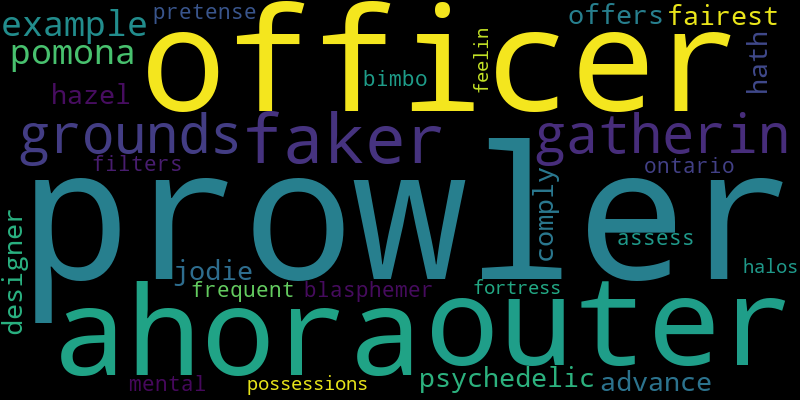

In [255]:
wc_list[1]

# Word2Vec Processing

In [205]:
from nltk import word_tokenize,sent_tokenize
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    
    lowers=text.lower()
    break_hyphen_apos = lowers.replace("'s","").replace("'","")
    no_punctuation = break_hyphen_apos
    for sym in string.punctuation:
        no_punctuation = no_punctuation.replace(sym," ")
    tokens= nltk.word_tokenize(no_punctuation)
    lem_tokens =[]
    for w in tokens:
        try:
            lem_tokens.append(str(lemmatizer.lemmatize(w)))
        except:
            pass
    return lem_tokens
    

In [207]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):    
    df_out =df.copy(deep=True)
    for i,row in df_out.iterrows():
        df_out.at[i,'Lyrics'] = process(row['Lyrics'],lemmatizer)
    return df_out



In [208]:
processed_lyrics = process_all(pd.DataFrame(data['Lyrics']))
processed_lyrics.head()

                                              Lyrics
0  [i, never, wrote, a, love, song, that, didn, t...
1  [our, little, boy, is, four, year, old, and, q...
2  [too, much, of, anything, can, make, you, sick...
3  [look, around, help, me, out, breaking, up, br...
4  [why, can, t, you, just, believe, in, me, not,...


In [209]:
processed_lyrics.tail()

,Lyrics
11291,"[we, are, the, industry, people, with, this, d..."
11292,"[boom, semi, automatic, pulse, psyched, up, fo..."
11293,"[and, if, i, wa, wrong, again, what, else, hav..."
11294,"[you, should, listen, very, well, i, m, about,..."
11295,"[i, believe, i, believe, i, believe, i, believ..."


In [210]:
#quick sanity check on the data and processed tokenized lyric
data.tail()

,Artist,Song,Lyrics,Genre,labels
11291,Zeromancer,Industrypeople,We are the Industry people With this death ki...,metal,4
11292,Zeromancer,Raising Hell,Boom Semi automatic pulse Psyched up for the n...,metal,4
11293,Zornik,Once Again,And if I was wrong again What else have you ke...,rock,3
11294,Zornik,This Song Is Just For You,You should listen very well I m about to lose ...,rock,3
11295,Zwan,Honestly Album Version,I believe I believe I believe I believe the lo...,indie,0


In [211]:
def get_rare_words(processed_lyrics):
    all_tokens=[]
    for i,row in processed_lyrics.iterrows():
        all_tokens += row['Lyrics']
    count = Counter(all_tokens)
    count_dict = dict(count)
    return sorted([k for k in count_dict if count_dict[k]<=1])

In [212]:
def create_features(processed_lyrics,rare_words):
    lyrics_text =list(processed_lyrics['Lyrics'].apply(lambda x: ' '.join(w for w in x)))
    words_to_omit = [str(word) for word in rare_words + nltk.corpus.stopwords.words('english')]
    
    tfidf = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=words_to_omit)
#     print(lyrics_text[:3])
    feature_matrix = tfidf.fit_transform(lyrics_text)
    return (tfidf, feature_matrix)

## TFIDF feature matrix with more processing

In [221]:
rare_words = get_rare_words(processed_lyrics)
(tfidf, feature_matrix_tfidf) = create_features(processed_lyrics, rare_words)

In [222]:
tfidf_feat_dense = feature_matrix_tfidf.todense() #making a dense matrix to concatenate to full feature matrix with w2v features
tfidf_feat_dense.shape

(11296, 18678)

## Word2Vec feature extraction


                

Word2Vec is a class of neural network model developed to extract word vectors that are useful in NLP tasks. The neural network takes in a large corpus of text, analyzes it, and for each word in the vocabulary, generates a vector of numbers that represent that word. Those vectors are useful to signify important information about the meaning of the word in relation to the context in which it appears.

[Source:https://www.tensorflow.org/images/softmax-nplm.png]<img src="img/softmax-nplm.png">

In [223]:
s=[]
for i in range(len(processed_lyrics.Lyrics)): 
    m =(processed_lyrics.iloc[i].astype(list))
    f=' '.join(m[0])
    t=f.split()
    s.append(t)


In [224]:
num_features=150
downsampling = 1e-3
min_wordcount=3
num_workers=multiprocessing.cpu_count()
seed=1
context_size=7
corpus=s 


In [225]:
w2v_model = gensim.models.Word2Vec(sg=1,seed=seed,size=num_features,min_count=min_wordcount,window=context_size,sample=downsampling)
w2v_model.build_vocab(corpus)
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=10)

(17270826, 24913650)

In [226]:
#code to save the model to the local disk
if not os.path.exists("trained"):
    os.makedirs("trained")
w2v_model.save(os.path.join("trained", "w2v_model.w2v"))

## Visual Representation of Vocabulary trained with Word2Vec Using Seaborn

In the visualization below you can see that the words like "wander" and "escape" appear together and "hollow","darkness","mercy","pain" appear together!

In [230]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0,learning_rate=200.0, n_iter=250,verbose=0, random_state=seed,angle=0.5)
w2v_mat = w2v_model.wv.vectors
w2v_mat_2d = tsne.fit_transform(w2v_mat)

In [234]:
result =[]
for word in w2v_model.wv.vocab:
    rec=(word,w2v_mat_2d[w2v_model.wv.vocab[word].index])
    result.append(rec)

points=[]
for word,pts in result:
    rec=(word,pts[0],pts[1])
    points.append(rec)

plo_df = pd.DataFrame(points,columns=["word", "x", "y"])

len(plo_df.y)


13282

In [235]:
li_x = list(plo_df.x)
li_y = list(plo_df.y)
li_word = list(plo_df.word)
li_x[:10]

[0.0096932621672749519,
 0.011893876828253269,
 0.0047191604971885681,
 0.0061029852367937565,
 0.0064467703923583031,
 0.0023108129389584064,
 0.0099462596699595451,
 0.0086470842361450195,
 0.007257404737174511,
 0.0043367496691644192]

In [236]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='petra.shini', api_key='2WD1djeDjhtyuH5XDk78')

data = [go.Scatter(
            x=li_x[:1000],
            y=li_y[:1000],
            mode = 'markers+text',
            name='Markers and Text',
            text=li_word[:1000]
    )]

py.iplot(data, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~petra.shini/0 or inside your plot.ly account where it is named 'basic-bar'


In [237]:
token_list=[]
for i in range(len(processed_lyrics['Lyrics'])):
    token_list.append(processed_lyrics['Lyrics'].iloc[i])

In [238]:
wv_vocab=w2v_model.wv.vocab
wv_vocab=set(wv_vocab)
wv_vocab=list(wv_vocab)
len(wv_vocab)

13282

In [241]:
word2vec_token_list=[] 
for token in token_list: 
    vc_list=[] 
    for word in token:
        if (word in wv_vocab):
            vc_list.append(w2v_model.wv[word])
    word2vec_token_list.append(vc_list) 


In [242]:
word_vector_arr=[]
for i in range (len(word2vec_token_list)):
    word_vector_arr.append(np.sum(word2vec_token_list[i], axis=0)/len(word2vec_token_list[i]))

In [243]:
len(word_vector_arr)

11296

In [244]:
columns=["w2v_"+str(i) for i in range(1,151)] 

In [245]:
for x in range (len(word_vector_arr)):
    try:
        if(type(word_vector_arr[x])==float):
            word_vector_arr[x]=[0]*150
        word_vector_arr[x]=word_vector_arr[x].tolist()
    except:
         print("Exception with the record %d",i)

In [246]:
for x in range (len(word_vector_arr)):
    try:
        if(type(word_vector_arr[x])==float):
            word_vector_arr[x]=[0]*150
    except:
        print("Exception with the record %d",i)


In [247]:
w2v_features=pd.DataFrame(word_vector_arr,columns=columns)
w2v_features.head()


,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,...,w2v_141,w2v_142,w2v_143,w2v_144,w2v_145,w2v_146,w2v_147,w2v_148,w2v_149,w2v_150
0,0.091226,0.043216,0.021632,-0.266216,-0.012158,0.068803,0.241478,0.132305,-0.006555,-0.026983,...,-0.027611,0.084050,-0.106993,0.055456,0.009545,0.081817,0.033357,-0.023373,-0.120461,0.052595
1,0.077191,-0.001188,-0.080999,-0.227991,0.078716,0.008749,0.231695,0.161938,-0.017654,0.102774,...,0.001886,0.051436,-0.000795,0.139114,0.016408,0.082564,0.094837,0.017562,-0.003645,-0.017547
2,0.021176,0.035554,-0.013146,-0.316167,-0.126101,-0.029613,0.191664,0.192894,0.062167,0.027285,...,-0.018484,0.127104,0.058654,0.116177,-0.063940,0.056207,-0.051344,0.017871,-0.015343,0.057000
3,-0.050631,0.003183,-0.012037,-0.234254,0.063036,0.046872,0.276216,0.130091,0.006562,0.023117,...,-0.027318,0.132657,-0.043840,0.100148,-0.110978,0.004001,0.052179,0.033272,-0.055871,-0.021016
4,0.051861,0.040565,0.023340,-0.326930,-0.013760,0.065183,0.236713,0.107732,-0.034442,0.020876,...,-0.040938,0.150314,-0.046189,0.067806,-0.052085,0.137402,0.007252,-0.002269,-0.084334,0.044543


## Concatenating feature matrices

We concatenate the TFIDF feature matrix and the Word2Vec feature matrix to create a new robust model. We convert the matrices into dataframes and concat the two dataframes. We shall use this trained dataframe to perform classification of genres using different models.

In [249]:
tfidf_features = pd.DataFrame(tfidf_feat_dense)
full_df = pd.concat([w2v_features,tfidf_features ],axis=1)
full_df.head()

,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,...,18668,18669,18670,18671,18672,18673,18674,18675,18676,18677
0,0.091226,0.043216,0.021632,-0.266216,-0.012158,0.068803,0.241478,0.132305,-0.006555,-0.026983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.077191,-0.001188,-0.080999,-0.227991,0.078716,0.008749,0.231695,0.161938,-0.017654,0.102774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.021176,0.035554,-0.013146,-0.316167,-0.126101,-0.029613,0.191664,0.192894,0.062167,0.027285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.050631,0.003183,-0.012037,-0.234254,0.063036,0.046872,0.276216,0.130091,0.006562,0.023117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.051861,0.040565,0.023340,-0.326930,-0.013760,0.065183,0.236713,0.107732,-0.034442,0.020876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting into train and test

We split the data into train and test. 80 % train data and 20 % test data

In [250]:
train,test,train_y,test_y = train_test_split(full_df,lab,train_size=0.8)

## Using various classifiers to classify the genres and calculating accuracy scores 

The different classifiers we use are :

1. Dummy Classifier
2. SVM
3. K-Nearest Neighbour Classifier
4. Gradient Boost Classifier
5. Neural Network MLP Classifier
6. Random Forest Classifier
7. Adaboost Classifier
8. Logistic Regression
9. Gaussian Naive Bayes

## Dummy Classifier

In [251]:
d = DummyClassifier()
d.fit(train,train_y)
pred = d.predict(test)
dummy_class_acc_score=d.score(test,test_y)
dummy_class_acc_score

0.23141592920353982

## SVM

In [252]:
SV = LinearSVC(max_iter=10000)
SV.fit(train,train_y)
pred = SV.predict(test)
svm_acc_score=SV.score(test,test_y)
svm_acc_score

0.69026548672566368

## KNN Classifier

In [253]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train,train_y) 
pred = neigh.predict(test)
knn_acc_score=neigh.score(test,test_y)
knn_acc_score

0.43141592920353983

## Gradient Boosting classifier

In [ ]:
gd = GradientBoostingClassifier(max_depth=5,n_estimators=1000)
gd.fit(train,train_y)
pred = gd.predict(test)
gd_acc_score=gd.score(test,test_y)
gd_acc_score

## Neutral Network : MLP Classifier

In [ ]:
nn = MLPClassifier()
nn.fit(train,train_y)
pred = nn.predict(test)
nn_acc_score=nn.score(test,test_y)
nn_acc_score

## Random Forest Classifier

In [256]:
RF = RandomForestClassifier()
RF.fit(train,train_y)
pred = RF.predict(test)
rf_acc_score=RF.score(test,test_y)
rf_acc_score

0.67654867256637163

## Adaboost Classifier

In [257]:
ad = AdaBoostClassifier()
ad.fit(train,train_y)
pred = ad.predict(test)
ad_acc_score=ad.score(test,test_y)
ad_acc_score

0.47522123893805307

## Logistic Regression

In [258]:
logreg = LogisticRegression()
logreg = logreg.fit(train, train_y)
pred=logreg.predict(test)
lg_acc_score=logreg.score(test,test_y)
lg_acc_score

0.60663716814159296

## Gaussian Naive Bayes

In [261]:
NB = GaussianNB()
NB.fit(train,train_y)
pred = NB.predict(test)
nb_acc_score=NB.score(test,test_y)
nb_acc_score

0.58362831858407083

## Creating a list of Classifiers and Accuracies

In [ ]:
classifier_list =["Dummy","Support Vector Machine","K-Nearest Neighbours","Gradient Boosting","MLP classifier","Random Forest","Ada Boost","Logistic Regression","Gaussian Naive Bayes"]
accuracy_list=[dummy_class_acc_score,svm_acc_score,knn_acc_score,gd_acc_score,nn_acc_score,rf_acc_score,ad_acc_score,lg_acc_score,nb_acc_score]

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='petra.shini', api_key='2WD1djeDjhtyuH5XDk78')
graph = [go.Bar(
            x=pd.DataFrame(classifier_list),
            y=pd.DataFrame(accuracy_list)
    )]

py.iplot(graph, filename='basic-bar')

# References and Future Work

https://github.com/sarthak18593/Music-Genre-Classification-by-Lyric-Analysis

https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE/blob/master/Thrones2Vec.ipynb


https://www.tensorflow.org/tutorials/word2vec


https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. 
The Million Song Dataset. In Proceedings of the 12th International Society
for Music Information Retrieval Conference (ISMIR 2011), 2011.